In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
import os
import sys
import sklearn
import matplotlib.pyplot as plt
import datetime

In [2]:
db_path = os.path.join(os.getcwd(),'data/game_database.sqlite3')
con = sqlite3.connect(db_path)
print(con)

In [3]:
# generate dataframe from database
query = """
SELECT * FROM metadata;
"""
meta_df = pd.read_sql(query, con)

In [4]:
def get_winner(row): # return winner's tag, quitter is chosen as loser
    if row["lras"] == 0:
        return row["player_2_tag"]
    if row["player_1_end_stocks"] == 0:
        return row["player_2_tag"]
    elif (row["player_1_end_stocks"] == row["player_2_end_stocks"]) & (row["player_1_end_dmg"] > row["player_2_end_dmg"]):
        return row["player_2_tag"]
    else:
        return row["player_1_tag"]        
    
def winner_char(row): # return winner's character
    if row["lras"] == 0:
        return row["player_2_char"]
    if row["player_1_end_stocks"] == 0:
        return row["player_2_char"]
    elif (row["player_1_end_stocks"] == row["player_2_end_stocks"]) & (row["player_1_end_dmg"] > row["player_2_end_dmg"]):
        return row["player_2_char"]
    else:
        return row["player_1_char"]  

def get_quitter(row): #replace quitter port value with tag
    if row['lras'] == 0:
        return row['player_1_tag']
    elif row['lras'] == 1:
        return row['player_2_tag']

def yari_char(row): # create a column with my character for that game for easy aggregation
    if row ['player_1_tag'] == "YARI#105":
        return row['player_1_char']
    else:
        return row['player_2_char']
    
meta_df['lras'] = meta_df.apply(get_quitter,axis=1)   
meta_df["winner_char"] = meta_df.apply(winner_char,axis=1)
meta_df["winner"] = meta_df.apply(get_winner,axis=1)
meta_df['date'] = pd.to_datetime(meta_df['date'])

In [5]:
meta_df.head()

,date,path,duration_frames,player_1_tag,player_1_char,player_1_end_stocks,player_1_end_dmg,player_2_tag,player_2_char,player_2_end_stocks,player_2_end_dmg,stage,end_method,lras,winner_char,winner
0,2020-08-14 00:47:58+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,12092,YARI#105,FOX,0,60.950001,GSTE#771,FOX,2,68.880005,BATTLEFIELD,GAME,None,FOX,GSTE#771
1,2020-08-21 22:09:21+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,12255,STU#644,FOX,2,28.100000,YARI#105,FOX,0,122.919998,FOUNTAIN_OF_DREAMS,GAME,None,FOX,STU#644
2,2020-08-30 20:31:13+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,8322,CHAR#134,FALCO,2,12.460000,YARI#105,FALCO,0,31.459999,BATTLEFIELD,GAME,None,FALCO,CHAR#134
3,2020-08-30 20:33:37+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,8672,CHAR#134,FALCO,1,44.649998,YARI#105,FALCO,3,116.869995,DREAM_LAND_N64,NO_CONTEST,CHAR#134,FALCO,CHAR#134
4,2020-08-30 20:36:08+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,13674,CHAR#134,MARTH,1,18.450001,YARI#105,MARTH,0,164.350006,YOSHIS_STORY,GAME,None,MARTH,CHAR#134


In [6]:
method = meta_df['end_method'].value_counts()
quits = meta_df['lras'].value_counts()
print(f"Method of game end: {len(meta_df)} games\n",'-'*20,sep="")
for x in method.keys():
    print(f'{x}: \n\t{method.get(x)}, \n\t{method.get(x) / len(meta_df):.2%}')
    
print('-'*20,
      f"\nQuit outs: {sum(quits)} quits\n",
      '-'*20,sep="")
print(f'My Quits: \n\t{quits["YARI#105"]}, \n\t{quits["YARI#105"] / sum(quits):.2%}\nOpponent Quits: \n\t{sum(quits)-quits["YARI#105"]}, \n\t{(sum(quits)-quits["YARI#105"])/sum(quits):.2%}')

Method of game end: 9467 games
--------------------
GAME: 
	6846, 
	72.31%
NO_CONTEST: 
	2621, 
	27.69%
--------------------
Quit outs: 2621 quits
--------------------
My Quits: 
	1454, 
	55.48%
Opponent Quits: 
	1167, 
	44.52%


# Winrates

Starting off this analysis, let's look at overall winrate and track it over time.  The easiest way to put this together is using a SQL query for easy date grouping and compare monthly winrates.  An important note here is that a pseudo-ranked ELO system was added in Version 2.2.4.  This change was implemented to pair lower-skill players together, however the pairing becomes weaker with average skill and above players.  In general, this means that with a low winrate, you are more likely to be paired with weaker skilled players, but as your winrate increases you are more likely to be paired with a wider skill-range.  More info can be found here:   <a href=https://twitter.com/fizzi36/status/135178978021693850> Fizzi's Twitter thread</a>

Version 2.2.4 released Jan 19, 2021, a vertical line is added for February 2021 (since this is the start of the first fully valid month, and over half of January had finished) to represent the addition of soft Skill Based Matchmaking (SBMM).

In [7]:
query = """
    WITH test_df AS (
    SELECT *,
        CASE
            WHEN lras = 1
                THEN player_1_char
            WHEN lras = 0
                THEN player_2_char
            WHEN player_1_end_stocks = 0
                THEN player_2_char
            ELSE player_1_char 
            END AS winner_char,
        CASE
            WHEN lras = 1
                THEN player_1_tag
            WHEN lras = 0
                THEN player_2_tag
            WHEN player_1_end_stocks = 0
                THEN player_2_tag
            ELSE player_1_tag
            END AS winner_tag
            
    FROM metadata
    )
    
    SELECT
        strftime('%m-%Y', date) as month,
        AVG(CASE
            WHEN winner_tag = 'YARI#105'
            THEN 1
            ELSE 0
            END) winrate,
        COUNT(winner_tag) games_played
    FROM
        test_df           
    GROUP BY
        strftime('%m-%Y', date)
    ORDER BY
        date
        """
monthly_winrates = pd.read_sql(query,con)

Overall Winrate: 37.10%


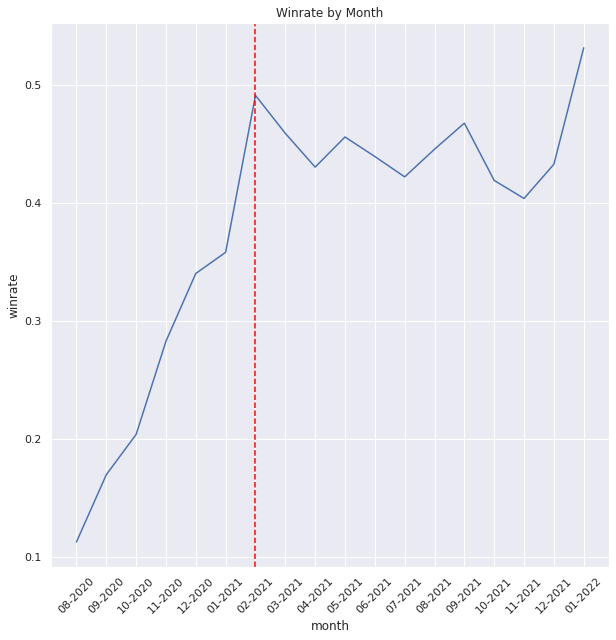

In [8]:
%matplotlib inline
print(f"Overall Winrate: {len(meta_df[meta_df['winner'] == 'YARI#105'])/len(meta_df):.2%}")
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(data=monthly_winrates, x='month',y='winrate')
plt.xticks(rotation=45)
plt.axvline(x='02-2021', ls='--', color="red")
plt.title('Winrate by Month')
plt.show()

We see a sharp increase in winrate up until the first month of active SBMM, given August 2020 was the start of my competitive journey, this could indicate a rapid growth in skill (while still winning less than half the games player) while likely also sticking around only in games where I'm likely to win.  After the addition of MMR, it's harder to quit out and find a lower-skilled player as it's more likely to be paired with a similarly skilled opponent at each game.  To explore this further, we can look at quit-out rates.  

In [9]:
%matplotlib inline
get_quitter = """
    SELECT * 
    FROM metadata
"""
pd.read_sql(get_quitter, con)

,date,path,duration_frames,player_1_tag,player_1_char,player_1_end_stocks,player_1_end_dmg,player_2_tag,player_2_char,player_2_end_stocks,player_2_end_dmg,stage,end_method,lras
0,2020-08-14 00:47:58+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,12092,YARI#105,FOX,0,60.950001,GSTE#771,FOX,2,68.880005,BATTLEFIELD,GAME,NaN
1,2020-08-21 22:09:21+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,12255,STU#644,FOX,2,28.100000,YARI#105,FOX,0,122.919998,FOUNTAIN_OF_DREAMS,GAME,NaN
2,2020-08-30 20:31:13+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,8322,CHAR#134,FALCO,2,12.460000,YARI#105,FALCO,0,31.459999,BATTLEFIELD,GAME,NaN
3,2020-08-30 20:33:37+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,8672,CHAR#134,FALCO,1,44.649998,YARI#105,FALCO,3,116.869995,DREAM_LAND_N64,NO_CONTEST,0.0
4,2020-08-30 20:36:08+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,13674,CHAR#134,MARTH,1,18.450001,YARI#105,MARTH,0,164.350006,YOSHIS_STORY,GAME,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,2022-01-04 21:14:12+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,7259,LUNA#973,MARTH,2,0.000000,YARI#105,MARTH,0,64.019997,BATTLEFIELD,GAME,NaN
9463,2022-01-04 21:16:29+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,11299,YARI#105,JIGGLYPUFF,2,97.442268,VIBE#773,JIGGLYPUFF,0,124.420013,BATTLEFIELD,GAME,NaN
9464,2022-01-04 21:19:45+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,13639,YARI#105,PEACH,0,97.940002,VIBE#773,PEACH,3,184.606979,FINAL_DESTINATION,GAME,NaN
9465,2022-01-04 21:23:41+00:00,/media/beastman/36E8AEA6E8AE63B9/Users/newco/D...,7481,YARI#105,PEACH,2,165.401566,VIBE#773,PEACH,3,41.735100,DREAM_LAND_N64,NO_CONTEST,0.0


## Matchups 

Characters are broken up by their community-defined tier list, below I will be exploring my within-tier winrates and winrates by tier vs my top 5 played characters.

In [10]:
meta_characters = {
                   'TOP':{
                        'S':{'FOX','JIGGLYPUFF','MARTH','FALCO'},
                        'A':{'SHEIK','CAPTAIN_FALCON','PEACH'}
                   },
                   'MID':{
                       'B+':{'POPO','PIKACHU','YOSHI','SAMUS'}, 
                       'B-':{'LUIGI','DR_MARIO'},
                       'C+':{'GANONDORF','MARIO'},
                       'C-':{'DONKEY_KONG','YOUNG_LINK','LINK','GAME_AND_WATCH'}
                   },
                   'LOW':{
                       'D':{'MEWTWO','ROY','PICHU','NESS','ZELDA'},
                       'F':{'KIRBY','BOWSER'}
                   }
                  }


In [11]:
for tier in meta_characters:
    print(tier,meta_characters[tier].values())

TOP dict_values([{'MARTH', 'JIGGLYPUFF', 'FALCO', 'FOX'}, {'PEACH', 'SHEIK', 'CAPTAIN_FALCON'}])
MID dict_values([{'PIKACHU', 'YOSHI', 'SAMUS', 'POPO'}, {'DR_MARIO', 'LUIGI'}, {'MARIO', 'GANONDORF'}, {'DONKEY_KONG', 'GAME_AND_WATCH', 'YOUNG_LINK', 'LINK'}])
LOW dict_values([{'MEWTWO', 'NESS', 'ZELDA', 'ROY', 'PICHU'}, {'BOWSER', 'KIRBY'}])


In [12]:
#con.close()